In [1]:
import numpy as np

### Layer Abstract Class

In [2]:
class Layer():
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, accum_grad, learning_rate):
        raise NotImplementedError()       

### Dense Layer

In [3]:
import math

class Dense(Layer):
    def __init__(self, input_dim, output_dim):
        # Reference : https://keras.io/api/layers/initializers/
        #limit = np.sqrt(6/(input_dim+output_dim))
        #self.W = np.random.uniform(-limit, limit, size=(input_dim, output_dim))
        self.W = np.random.randn(input_dim, output_dim) * 0.1
        self.b = np.zeros(output_dim)
        self.x_save = None # saving input x in forward step for using in backward step
        
    def forward(self, x):
        # x : (batch, input_dim)
        self.x_save = x
        
        # Dense layer를 수식으로 표현하면 다음과 같습니다.
        # y = x@W + b
        
        # (batch, output_dim)
        y = x @ self.W + self.b
        
        return y
        
    def backward(self, accum_grad, learning_rate):
        # accum_grad : ∂L/∂y, (batch, output_dim)
        
        # y를 W에 대해 미분하면 다음과 같이 되고,
        # ∂y/∂W = x
        
        # Loss를 W에 대해 미분하면 chain rule에 의해 다음과 같이 표현됩니다.
        # ∂L/∂W = ∂L/∂y·∂y/∂W = ∂L/∂y·x
        
        # (input_dim, output_dim)
        W_grad = self.x_save.T @ accum_grad
        
        # 또한 y를 b에 대해 미분하면 다음과 같이 되고,
        # ∂y/∂b = 1
        
        # Loss를 b에 대해 미분하면 chain rule에 의해 다음과 같이 표현됩니다.
        # ∂L/∂b = ∂L/∂y·∂y/∂b = ∂L/∂y·1
        b_grad = np.sum(accum_grad, axis=0)
        
        # Loss를 x에 대해 미분하면 chain rule에 의해 다음과 같이 표현됩니다.
        # ∂L/∂x = ∂L/∂y·∂y/∂x
        # y를 x에 대해 미분하면 다음과 같이 됩니다.
        # ∂y/∂x = W
        accum_grad = accum_grad @ self.W.T

        # Weight&bias 업데이트
        self.W = self.W - learning_rate * W_grad
        self.b = self.b - learning_rate * b_grad
        
        return accum_grad
            

### Activations

In [4]:
# Reference : https://github.com/eriklindernoren/ML-From-Scratch/blob/master/mlfromscratch/deep_learning/activation_functions.py
class Sigmoid(Layer):
    def forward(self, x):
        self.x_save = x
        return 1 / (1 + np.exp(-x))
    
    def backward(self, accum_grad, learning_rate):
        grad = self.forward(self.x_save) * (1 - self.forward(self.x_save))
        return accum_grad * grad

class ReLU(Layer):
    def forward(self, x):
        self.x_save = x
        return np.where(x>0, x, 0)
    
    def backward(self, accum_grad, learning_rate):
        grad = np.where(self.x_save>0, 1, 0)
        return accum_grad * grad
    
class Tanh(Layer):
    def forward(self, x):
        self.x_save = x
        return 2 / (1 + np.exp(-2*x)) - 1
    
    def backward(self, accum_grad, learning_rate):
        grad = 1 - np.power(self.forward(self.x_save), 2)
        return accum_grad * grad
        

### Sequential Layer

In [5]:
class Sequential(Layer):
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, x):
        # x : (batch, input_dim)
        
        for layer in self.layers:
            x = layer.forward(x)
            
        return x
    
    def backward(self, accum_grad, learning_rate):
        
        for layer in reversed(self.layers):
            accum_grad = layer.backward(accum_grad, learning_rate)
            
        return accum_grad

### Losses

In [6]:
class MeanSquareError():
    @staticmethod
    def get_loss(y_pred, y_true):
        # y_pred : (batch, dim)
        # y_true : (batch, dim)
        
        # scalar
        loss = 0.5 * np.mean((y_pred - y_true) ** 2)
        
        return loss
    
    @staticmethod
    def get_gradient(y_pred, y_true):
        grad = -y_true + y_pred
        
        return grad
    
from scipy.special import softmax
class SparseCrossEntropy():
    # Reference : https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1
    @staticmethod
    def get_loss(y_pred, y_true):
        # y_pred : (batch, dim)
        # y_true : (batch,)
        
        eps = np.finfo(float).eps
        log_p = np.log(softmax(y_pred, axis=1) + eps)
        
        negative_log_likelihoods = []
        for i, target in enumerate(y_true):
            nll = -log_p[i, target]
            negative_log_likelihoods.append(nll)
            
        loss = np.mean(negative_log_likelihoods)
        
        return loss
    
    @staticmethod
    def get_gradient(y_pred, y_true):
        # y_pred : (batch, dim)
        # y_true : (batch,)
        
        y_true = np.eye(y_pred.shape[1])[y_true]
        grad = softmax(y_pred, axis=1) - y_true
        return grad
    

### Data preparation

In [7]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset = dataset.fillna(dataset.mean())

origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

print(normed_train_data.shape, normed_test_data.shape)
print(train_labels.shape, test_labels.shape)

(318, 9) (80, 9)
(318,) (80,)


### Model setup

In [20]:
model = Sequential([Dense(9, 64),
                    ReLU(),
                    Dense(64, 64),
                    ReLU(),
                    Dense(64, 1),
                   ])
print(model)

### Model Training (Fit)

In [21]:
losses = []

# (batch, 9)
x = normed_train_data.to_numpy()
# (batch, 1)
t = train_labels.to_numpy().reshape(-1, 1)

from tqdm import tqdm
for i in range(1000):
    
    # Forward Pass
    # (batch, 1)
    y = model.forward(x)
    
    # Get Loss
    loss = MeanSquareError.get_loss(y, t)
    print('Epoch :', i, 'Loss :', loss)
    
    # Backward Pass
    grad = MeanSquareError.get_gradient(y, t)
    model.backward(grad, learning_rate=1e-5)
    
    # Append loss
    losses.append(loss)
    
print('done')

Epoch : 0 Loss : 308.8750141590762
Epoch : 1 Loss : 305.2696688877288
Epoch : 2 Loss : 301.5952089712653
Epoch : 3 Loss : 297.71695014336785
Epoch : 4 Loss : 293.4801140667641
Epoch : 5 Loss : 288.6907577832131
Epoch : 6 Loss : 283.11919959030075
Epoch : 7 Loss : 276.4470631669098
Epoch : 8 Loss : 268.27311328519244
Epoch : 9 Loss : 257.996535400068
Epoch : 10 Loss : 244.82535439609157
Epoch : 11 Loss : 227.69268420582407
Epoch : 12 Loss : 205.395792202185
Epoch : 13 Loss : 176.8395486445952
Epoch : 14 Loss : 141.97293024126262
Epoch : 15 Loss : 103.84339817365816
Epoch : 16 Loss : 69.40289540758397
Epoch : 17 Loss : 46.106522209646634
Epoch : 18 Loss : 34.297721736612864
Epoch : 19 Loss : 28.150657293177872
Epoch : 20 Loss : 23.714815827883395
Epoch : 21 Loss : 20.039279142471482
Epoch : 22 Loss : 16.99637053303391
Epoch : 23 Loss : 14.552053572780077
Epoch : 24 Loss : 12.639820539908495
Epoch : 25 Loss : 11.175381621864597
Epoch : 26 Loss : 10.07597132521288
Epoch : 27 Loss : 9.25730

Epoch : 276 Loss : 3.372565785962474
Epoch : 277 Loss : 3.3710125332213843
Epoch : 278 Loss : 3.369490977069206
Epoch : 279 Loss : 3.367970926848545
Epoch : 280 Loss : 3.3664414319528966
Epoch : 281 Loss : 3.3649322130512367
Epoch : 282 Loss : 3.3634202900318857
Epoch : 283 Loss : 3.3618945516832612
Epoch : 284 Loss : 3.3603971096642953
Epoch : 285 Loss : 3.3589073327549728
Epoch : 286 Loss : 3.3574218712025323
Epoch : 287 Loss : 3.355951997908993
Epoch : 288 Loss : 3.354457751920091
Epoch : 289 Loss : 3.3529872806868366
Epoch : 290 Loss : 3.351520995622391
Epoch : 291 Loss : 3.350043405505493
Epoch : 292 Loss : 3.348596695170154
Epoch : 293 Loss : 3.3471482184088472
Epoch : 294 Loss : 3.345687099316552
Epoch : 295 Loss : 3.3442413450987534
Epoch : 296 Loss : 3.342771351997795
Epoch : 297 Loss : 3.3412983606212654
Epoch : 298 Loss : 3.3398070721878144
Epoch : 299 Loss : 3.338305623422062
Epoch : 300 Loss : 3.3367983464758133
Epoch : 301 Loss : 3.335298856843769
Epoch : 302 Loss : 3.333

Epoch : 553 Loss : 3.089061061129036
Epoch : 554 Loss : 3.0883579449605585
Epoch : 555 Loss : 3.087694646131067
Epoch : 556 Loss : 3.087010593365555
Epoch : 557 Loss : 3.0863242204910915
Epoch : 558 Loss : 3.0856190390257945
Epoch : 559 Loss : 3.084936361252079
Epoch : 560 Loss : 3.0842761393334777
Epoch : 561 Loss : 3.0835639324547595
Epoch : 562 Loss : 3.0828838988782445
Epoch : 563 Loss : 3.082212217673474
Epoch : 564 Loss : 3.0815279011705767
Epoch : 565 Loss : 3.0808451658178315
Epoch : 566 Loss : 3.080156829448767
Epoch : 567 Loss : 3.079463194872099
Epoch : 568 Loss : 3.078786692541805
Epoch : 569 Loss : 3.078132122162493
Epoch : 570 Loss : 3.0774829911549655
Epoch : 571 Loss : 3.0767941576193936
Epoch : 572 Loss : 3.0761316722742955
Epoch : 573 Loss : 3.075482004721916
Epoch : 574 Loss : 3.0748191224871033
Epoch : 575 Loss : 3.074154496255461
Epoch : 576 Loss : 3.0735103163017294
Epoch : 577 Loss : 3.072855528232169
Epoch : 578 Loss : 3.0722017949999922
Epoch : 579 Loss : 3.071

Epoch : 819 Loss : 2.9385878377679684
Epoch : 820 Loss : 2.9380970401154283
Epoch : 821 Loss : 2.9376093953327933
Epoch : 822 Loss : 2.937175098172024
Epoch : 823 Loss : 2.936659084052811
Epoch : 824 Loss : 2.9362302607129664
Epoch : 825 Loss : 2.9357540529380826
Epoch : 826 Loss : 2.9352534431698625
Epoch : 827 Loss : 2.9347602767974554
Epoch : 828 Loss : 2.934289998170412
Epoch : 829 Loss : 2.9338256881733114
Epoch : 830 Loss : 2.9333367417792355
Epoch : 831 Loss : 2.932844263858304
Epoch : 832 Loss : 2.9323777715850405
Epoch : 833 Loss : 2.9319176143583996
Epoch : 834 Loss : 2.931421460427583
Epoch : 835 Loss : 2.930974177283116
Epoch : 836 Loss : 2.930528801660521
Epoch : 837 Loss : 2.9300623474275898
Epoch : 838 Loss : 2.9295919495795384
Epoch : 839 Loss : 2.9291416908731236
Epoch : 840 Loss : 2.928692680176314
Epoch : 841 Loss : 2.92824333379295
Epoch : 842 Loss : 2.927780330085541
Epoch : 843 Loss : 2.927330942262446
Epoch : 844 Loss : 2.926888246699745
Epoch : 845 Loss : 2.9264

### Test

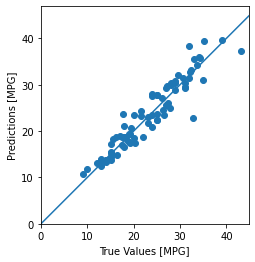

In [22]:
import matplotlib.pyplot as plt

x_test = normed_test_data.to_numpy()
t_test = test_labels.to_numpy().reshape(-1, 1)
y_test = model.forward(x_test)

plt.scatter(t_test[:, 0], y_test[:,0 ])
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])